<a href="https://colab.research.google.com/github/diperezbgit/IA-FUNDAMENTALS/blob/main/TAREA_2/TAREA_2_HC_SA_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem (VRP) para Optimización de Rutas en Conexiones Eléctricas
### Se tiene "n" cuadrillas (camiones) encargadas de atender un conjunto de conexiones eléctricas distribuidas en diferentes distritos. El objetivo es optimizar el tiempo total de atención mediante la determinación del orden óptimo en que la cuadrillas deben visitar cada punto de conexión.




# Carga y visualización de imagen GIS de asignación ordenes de trabajo


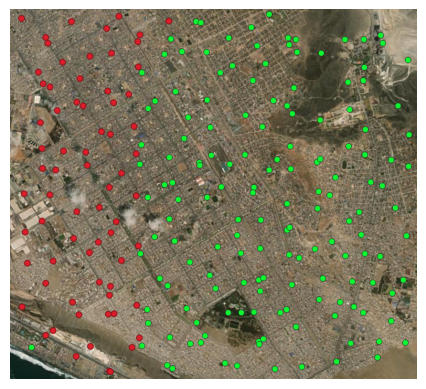

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

url = 'https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/main/TAREA_2/cnx_gis.png'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')  # Quita los ejes
plt.show()


# Importamos el archivo de ubicación de ordenes



In [ ]:
import pandas as pd
import numpy as np
#  obtenemos al archivo que contiene la informacion sobre las conexiones y ditancias entre ellas
path = r"https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/refs/heads/main/TAREA_2/cnx_cuadri02.csv"
df_long = pd.read_csv(path)
df_long

,id,y,x
0,0,8.651913e+06,286690.715164
1,1,8.651592e+06,287093.287133
2,2,8.651016e+06,286976.587931
3,3,8.651502e+06,287134.107559
4,4,8.650819e+06,287052.401729
...,...,...,...
219,219,8.647944e+06,292673.878297
220,220,8.647337e+06,292876.627498
221,221,8.646870e+06,292859.615044
222,222,8.646509e+06,293091.877356


# Función plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def plot_tsp_style_2(nodes, route, title, ax, time=None, fitness=None):
    """
    Soporta una ruta única (lista de nodos) o múltiples rutas (lista de listas).
    Leyenda en la esquina inferior derecha. Tiempo y fitness en la inferior izquierda.
    """
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)

    x, y = zip(*nodes)
    ax.scatter(x, y, c='black', s=50, zorder=2)
    ax.scatter(*nodes[0], c='yellow', s=100, edgecolors='black', label='Depósito', zorder=3)

    colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown']

    if isinstance(route[0], list):  # múltiples rutas (multivehículo)
        for idx, subroute in enumerate(route):
            if not subroute:
                continue
            full_route = [0] + subroute + [0]
            xs, ys = zip(*[nodes[i] for i in full_route])
            ax.plot(xs, ys, marker='o', color=colors[idx % len(colors)], label=f'Vehículo {idx+1}', zorder=1)
    else:  # ruta única
        full_route = list(route) + [route[0]]
        xs, ys = zip(*[nodes[i] for i in full_route])
        ax.plot(xs, ys, marker='o', color='blue', label='Ruta TSP', zorder=1)

    # Leyenda en esquina inferior derecha
    ax.legend(loc='lower right')

    # Texto de tiempo y fitness en esquina inferior izquierda
    if time is not None or fitness is not None:
        texto = ""
        if time is not None:
            texto += f"Time: {time:.2f} s\n"
        if fitness is not None:
            texto += f"Fitness: {fitness:.2f}"
        ax.text(0.05, 0.05, texto.strip(),
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment='bottom',
                horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0.8))




# Hill Climbing multiple

In [ ]:
import numpy as np, random, copy

def euclidean(p1, p2):
  return np.linalg.norm(np.array(p1) - np.array(p2))

def build_TSP(positions):
    return [[euclidean(p1, p2) for p2 in positions] for p1 in positions]

def fitness(routes, TSP):
    return sum(
        TSP[0][r[0]] + sum(TSP[r[i]][r[i+1]] for i in range(len(r)-1)) + TSP[r[-1]][0]
        for r in routes if r
    )

def initial_solution(n_customers, n_vehicles):
    clients = list(range(1, n_customers))  # excluir el depósito
    random.shuffle(clients)
    avg = len(clients) // n_vehicles
    return [clients[i*avg:(i+1)*avg] for i in range(n_vehicles-1)] + [clients[(n_vehicles-1)*avg:]]

def get_neighbors(routes):
    neighbors = []
    for i in range(len(routes)):
        for j in range(i, len(routes)):
            for a in range(len(routes[i])):
                for b in range(len(routes[j])):
                    if i == j and a == b: continue
                    new = copy.deepcopy(routes)
                    new[i][a], new[j][b] = new[j][b], new[i][a]
                    neighbors.append(new)
    return neighbors

def hill_climbing_multi(positions, n_vehicles):
    TSP = build_TSP(positions)
    current = initial_solution(len(positions), n_vehicles)
    init = copy.deepcopy(current)

    while True:
        neighbors = get_neighbors(current)
        best = min(neighbors, key=lambda r: fitness(r, TSP))
        if fitness(best, TSP) < fitness(current, TSP):
            current = best
        else:
            return current, fitness(current, TSP), init, fitness(init, TSP)


# Simulated Annealing multiple

In [ ]:
import numpy as np, random, copy

def euclidean(p1, p2): return np.linalg.norm(np.array(p1) - np.array(p2))

def build_TSP(positions):
    return [[euclidean(p1, p2) for p2 in positions] for p1 in positions]

def fitness(routes, TSP):
    return sum(
        TSP[0][r[0]] + sum(TSP[r[i]][r[i+1]] for i in range(len(r)-1)) + TSP[r[-1]][0]
        for r in routes if r
    )

def initial_solution(n_customers, n_vehicles):
    clients = list(range(1, n_customers))  # sin el depósito
    random.shuffle(clients)
    avg = len(clients) // n_vehicles
    return [clients[i*avg:(i+1)*avg] for i in range(n_vehicles-1)] + [clients[(n_vehicles-1)*avg:]]

def random_neighbor(sol):
    new = copy.deepcopy(sol)
    if len(sol) == 1:
        # Un solo vehículo: permutar dentro de la única ruta
        if len(sol[0]) >= 2:
            i, j = random.sample(range(len(sol[0])), 2)
            new[0][i], new[0][j] = new[0][j], new[0][i]
    else:
        # Múltiples vehículos: intercambiar clientes entre dos rutas
        r1, r2 = random.sample(range(len(sol)), 2)
        if sol[r1] and sol[r2]:
            i, j = random.randint(0, len(sol[r1])-1), random.randint(0, len(sol[r2])-1)
            new[r1][i], new[r2][j] = new[r2][j], new[r1][i]
    return new

def accept(delta, T):
    return delta < 0 or random.random() < np.exp(-delta / T)

def simulated_annealing_multi(positions, n_vehicles, T_max, T_min, cooling_rate):
    TSP = build_TSP(positions)
    x = initial_solution(len(positions), n_vehicles)
    E = fitness(x, TSP)
    sol_init = copy.deepcopy(x)
    T = T_max
    #E_list = []
    while T > T_min:
        x_new = random_neighbor(x)
        E_new = fitness(x_new, TSP)
        delta = E_new - E
        if accept(delta, T):
            x, E = x_new, E_new
            #E_list.append(E)
        T *= cooling_rate

    return x, E, sol_init, fitness(sol_init, TSP)#, E_list


# Ejecución de algoritmos

Inicial: [[6, 9, 5, 8], [7, 2, 1, 4, 3]] 
Costo inicial: 16034.278176819957
Final:   [[6, 7, 8, 9], [1, 3, 4, 5, 2]] 
Costo final:   10619.3536328947
Inicial: [[8, 5, 4, 9], [3, 6, 2, 7, 1]] 
Costo inicial: 18400.581370192056
Final:   [[4, 2, 3, 1], [5, 7, 8, 6, 9]] 
Costo final:   10837.699187034948


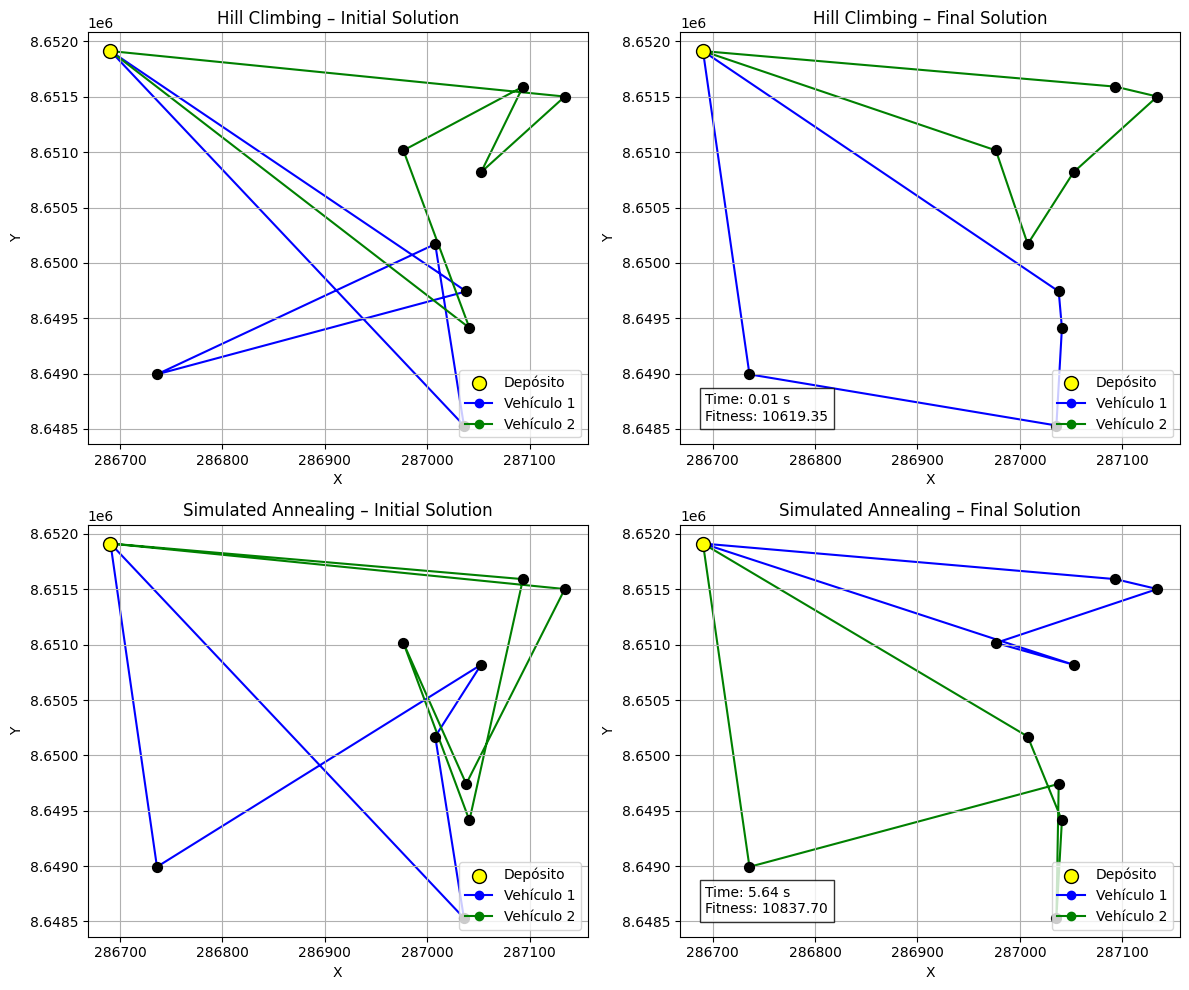

Inicial: [[3, 7, 2], [8, 1, 4], [6, 9, 5]] 
Costo inicial: 19612.654192323113
Final:   [[1, 3, 2], [9, 8, 7], [4, 6, 5]] 
Costo final:   13371.475476970158
Inicial: [[9, 8, 4], [1, 3, 2], [5, 7, 6]] 
Costo inicial: 14033.95346487828
Final:   [[5, 6, 4], [9, 8, 7], [2, 3, 1]] 
Costo final:   13371.475476970158


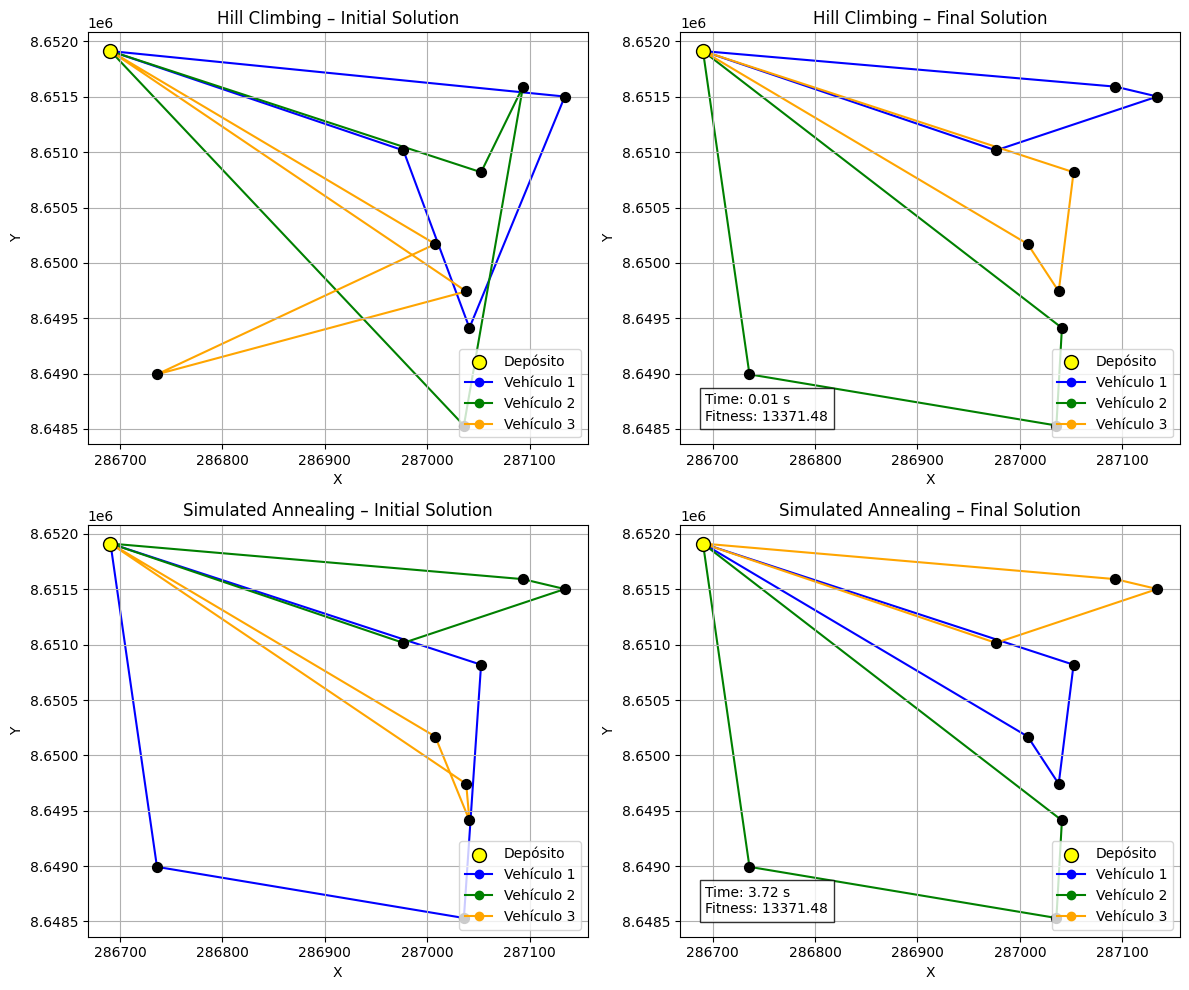

Inicial: [[6, 7], [8, 4], [1, 2], [9, 5, 3]] 
Costo inicial: 20005.498365522744
Final:   [[6, 7], [8, 9], [1, 3], [5, 4, 2]] 
Costo final:   16714.31662982377
Inicial: [[8, 3], [4, 9], [5, 6], [2, 7, 1]] 
Costo inicial: 22539.146498322993
Final:   [[6, 5], [1, 3], [4, 2], [9, 8, 7]] 
Costo final:   14797.597853830677


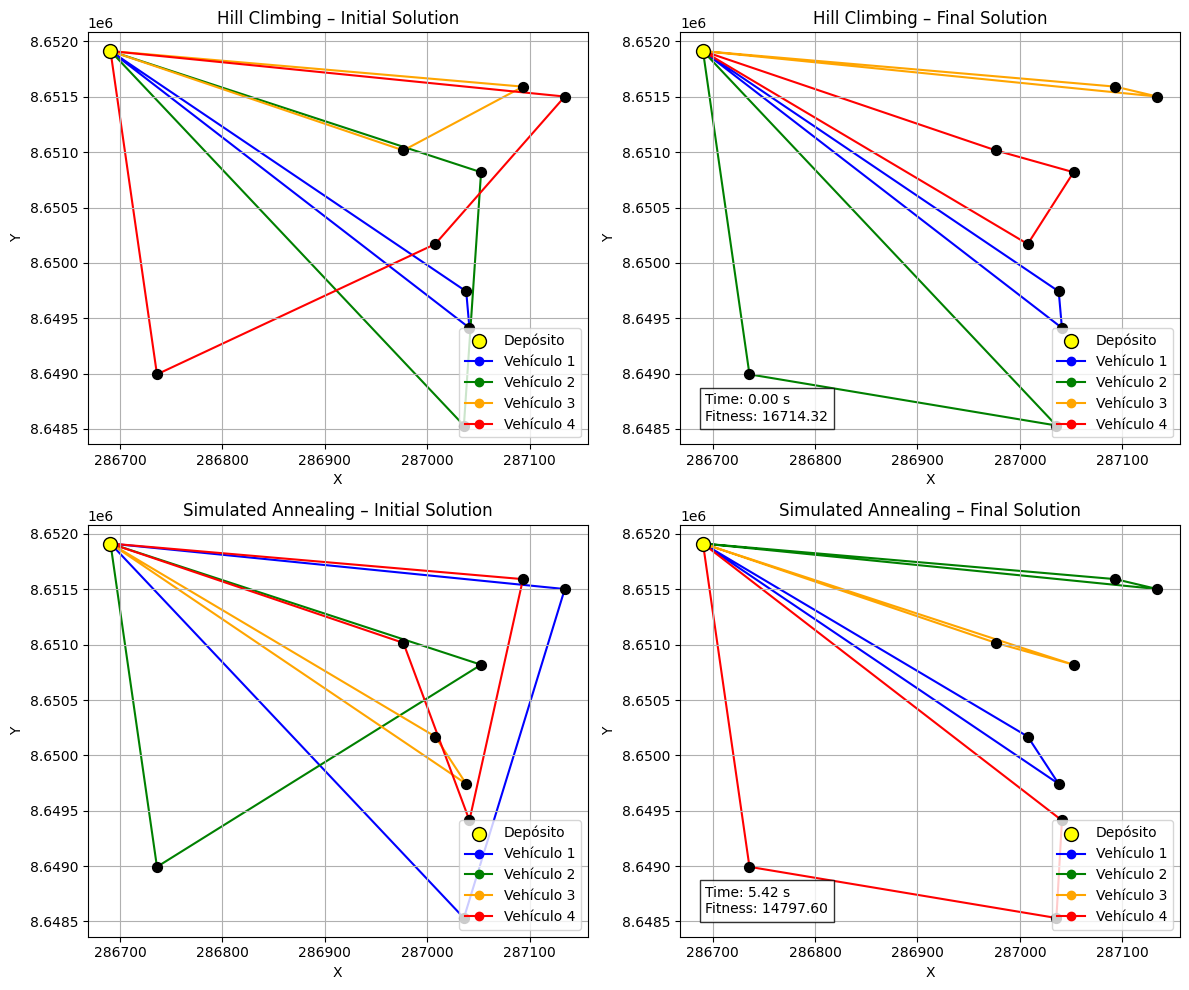

Inicial: [[19, 17, 11, 12, 13, 10, 23, 24, 21, 3, 16, 20], [8, 7, 5, 4, 9, 2, 15, 6, 22, 14, 18, 1]] 
Costo inicial: 38030.649226217975
Final:   [[7, 9, 10, 12, 14, 13, 11, 8, 23, 20, 18, 15], [2, 4, 17, 19, 5, 6, 21, 24, 22, 16, 3, 1]] 
Costo final:   19835.392066176388
Inicial: [[9, 13, 24, 2, 10, 16, 4, 1, 22, 20, 6, 12], [15, 14, 17, 23, 11, 7, 8, 5, 19, 18, 21, 3]] 
Costo inicial: 48854.9769081846
Final:   [[15, 16, 18, 20, 21, 7, 6, 19, 17, 4, 3, 1], [23, 22, 24, 11, 12, 14, 13, 10, 8, 9, 5, 2]] 
Costo final:   18379.74657554386


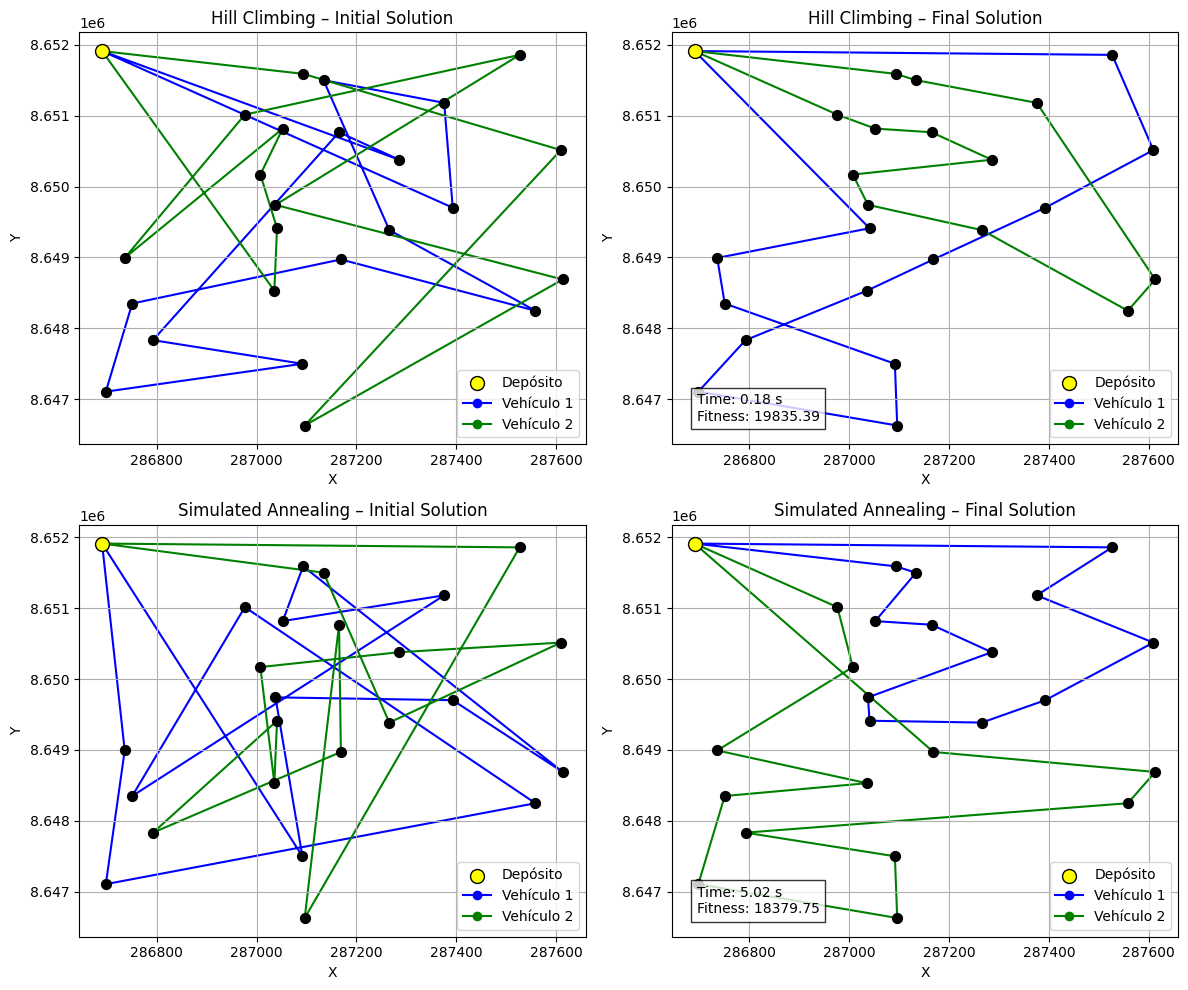

Inicial: [[24, 19, 2, 1, 14, 8, 12, 10], [13, 21, 6, 15, 11, 16, 4, 18], [9, 20, 22, 17, 7, 5, 3, 23]] 
Costo inicial: 55633.76081209781
Final:   [[9, 10, 11, 13, 14, 12, 8, 7], [1, 3, 16, 18, 19, 17, 4, 2], [20, 21, 22, 24, 23, 6, 5, 15]] 
Costo final:   23019.088398286825
Inicial: [[14, 18, 10, 21, 12, 3, 16, 7], [15, 2, 1, 17, 20, 8, 24, 23], [5, 11, 13, 19, 6, 22, 9, 4]] 
Costo inicial: 47288.68713009255
Final:   [[9, 13, 14, 12, 11, 10, 8, 7], [3, 2, 4, 17, 18, 16, 1, 15], [19, 20, 21, 22, 24, 23, 6, 5]] 
Costo final:   23217.666439602795


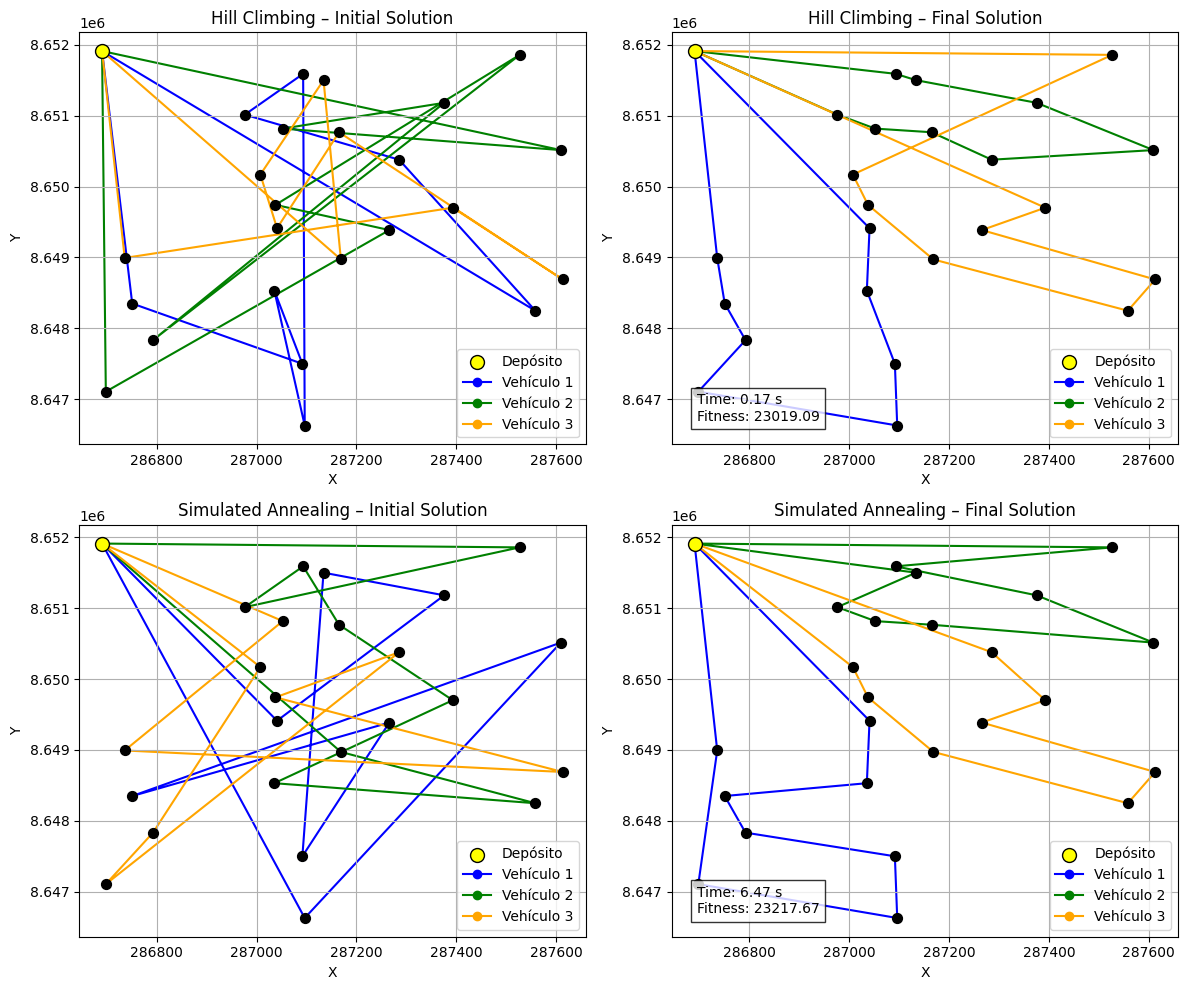

Inicial: [[19, 12, 17, 4, 5, 20], [22, 24, 6, 10, 15, 14], [11, 18, 23, 2, 3, 21], [7, 1, 13, 8, 9, 16]] 
Costo inicial: 62703.64183198979
Final:   [[3, 16, 17, 4, 2, 1], [22, 24, 8, 23, 21, 19], [5, 6, 7, 20, 18, 15], [12, 14, 13, 11, 10, 9]] 
Costo final:   27572.23812296648
Inicial: [[23, 9, 18, 22, 13, 11], [5, 14, 19, 12, 2, 4], [16, 15, 6, 17, 24, 3], [20, 21, 10, 1, 8, 7]] 
Costo inicial: 55346.88699998761
Final:   [[22, 24, 14, 13, 12, 11], [21, 7, 9, 8, 10, 23], [15, 1, 3, 16, 4, 2], [17, 5, 6, 20, 19, 18]] 
Costo final:   27977.526199054522


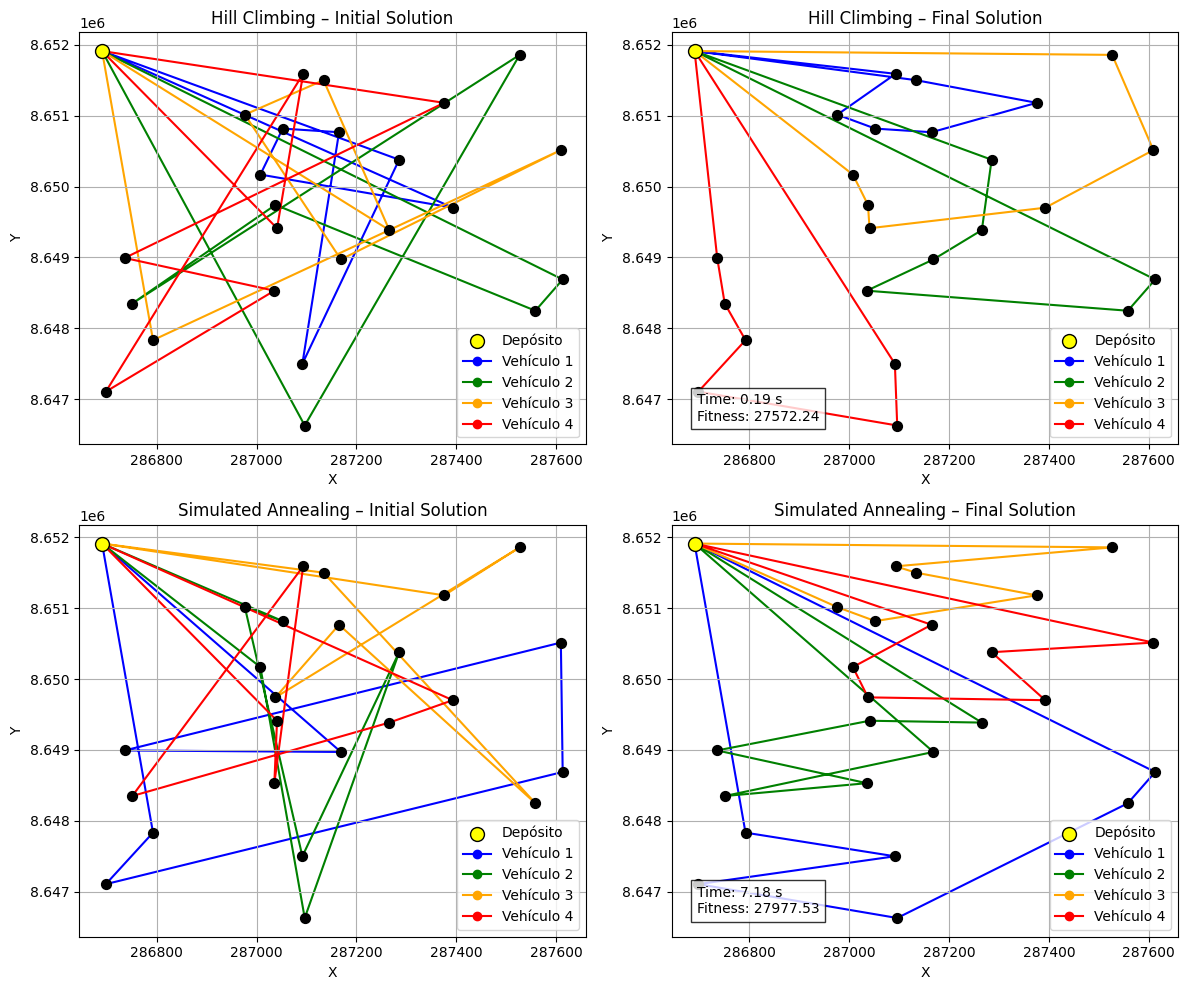

Inicial: [[26, 27, 30, 4, 14, 31, 23, 32, 36, 8, 42, 6, 43, 2, 24, 9, 37, 49, 41, 33, 40, 39, 10, 28], [35, 1, 15, 47, 38, 22, 45, 16, 3, 25, 11, 46, 29, 44, 20, 5, 7, 21, 13, 19, 48, 17, 18, 34, 12]] 
Costo inicial: 107617.5260790679
Final:   [[2, 4, 5, 19, 32, 31, 33, 34, 38, 22, 12, 26, 44, 43, 41, 25, 10, 8, 24, 42, 40, 39, 37, 36], [1, 3, 15, 30, 47, 48, 49, 21, 23, 28, 45, 46, 29, 27, 14, 13, 11, 9, 7, 6, 20, 35, 18, 17, 16]] 
Costo final:   32919.473866425746
Inicial: [[8, 21, 23, 4, 36, 18, 19, 22, 5, 43, 37, 41, 39, 48, 45, 26, 9, 29, 28, 42, 6, 35, 1, 20], [30, 32, 13, 2, 46, 25, 7, 14, 49, 33, 44, 31, 16, 24, 27, 15, 11, 3, 47, 34, 12, 38, 40, 10, 17]] 
Costo inicial: 111231.64900962991
Final:   [[9, 10, 42, 12, 26, 45, 46, 29, 14, 44, 43, 41, 28, 13, 27, 11, 25, 24, 40, 39, 37, 34, 31, 15], [1, 3, 18, 36, 38, 22, 8, 23, 7, 21, 6, 20, 5, 19, 4, 2, 16, 17, 32, 35, 33, 48, 49, 47, 30]] 
Costo final:   33735.43745232793


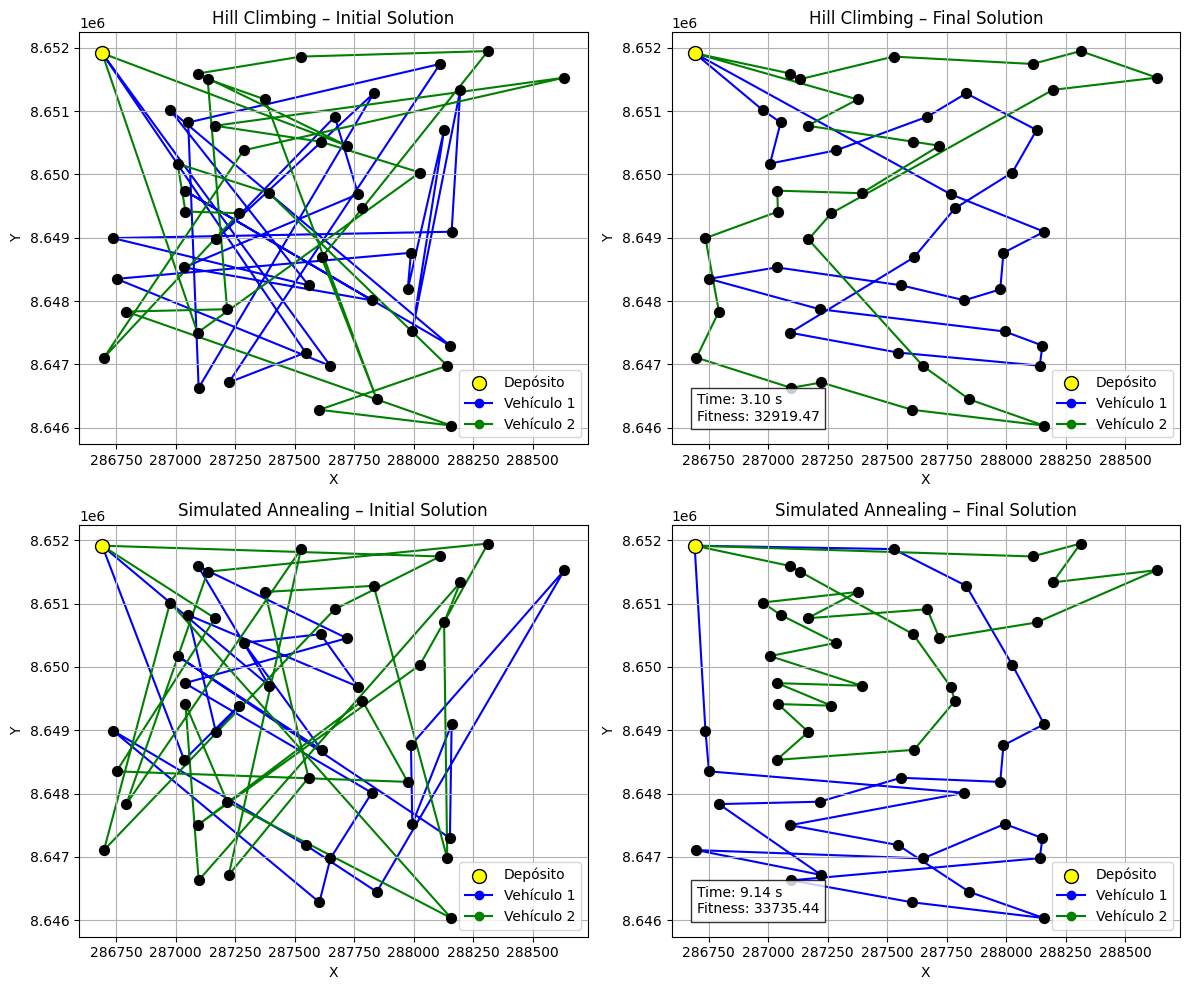

Inicial: [[3, 2, 6, 36, 18, 9, 24, 14, 42, 49, 44, 37, 47, 39, 46, 10], [40, 13, 15, 38, 20, 25, 7, 19, 22, 34, 21, 30, 29, 45, 12, 5], [28, 33, 4, 41, 48, 8, 1, 26, 11, 17, 16, 43, 35, 32, 27, 23, 31]] 
Costo inicial: 121224.5223272921
Final:   [[2, 5, 9, 11, 12, 13, 14, 27, 29, 28, 26, 41, 42, 40, 39, 19], [17, 18, 35, 20, 21, 23, 7, 6, 36, 38, 37, 43, 44, 46, 45, 4], [1, 3, 16, 32, 22, 24, 25, 10, 8, 34, 33, 31, 49, 48, 47, 30, 15]] 
Costo final:   39450.4333974878
Inicial: [[35, 31, 17, 23, 41, 38, 22, 49, 6, 33, 11, 4, 14, 29, 36, 19], [46, 8, 16, 24, 10, 44, 30, 12, 40, 2, 7, 27, 13, 28, 1, 18], [32, 37, 21, 34, 43, 3, 5, 15, 45, 48, 20, 47, 42, 26, 9, 25, 39]] 
Costo inicial: 119722.84056235608
Final:   [[4, 17, 5, 23, 8, 10, 11, 25, 42, 24, 22, 21, 7, 6, 19, 2], [9, 12, 13, 26, 43, 44, 14, 27, 29, 45, 46, 28, 41, 40, 39, 37], [3, 1, 48, 30, 33, 34, 36, 38, 20, 35, 18, 16, 32, 31, 49, 47, 15]] 
Costo final:   36601.64392029714


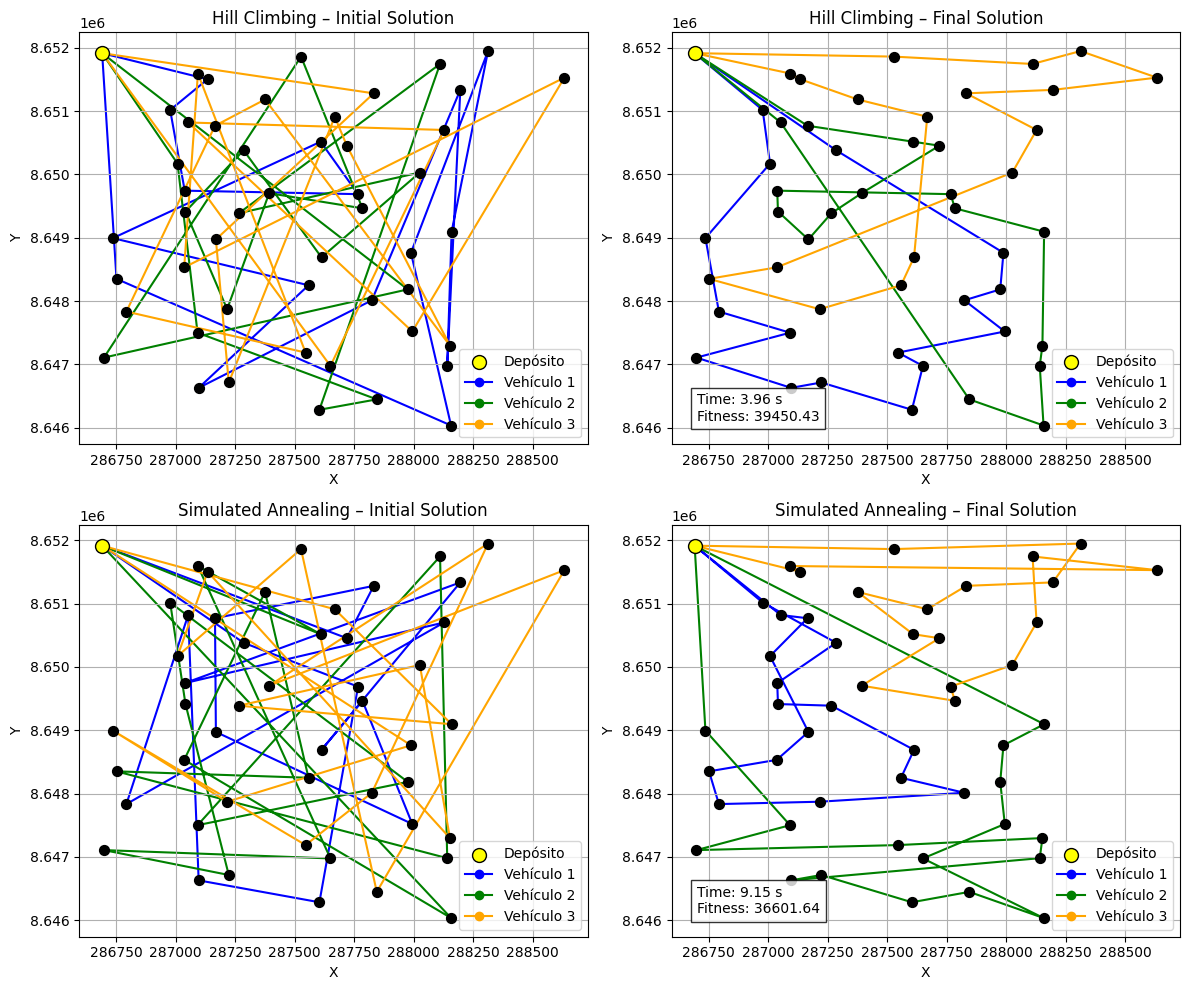

Inicial: [[47, 37, 42, 41, 17, 7, 8, 43, 16, 18, 35, 14], [44, 1, 21, 33, 15, 25, 12, 40, 2, 45, 49, 9], [19, 20, 27, 3, 13, 11, 22, 48, 28, 23, 29, 39], [26, 6, 32, 4, 38, 46, 36, 5, 34, 30, 31, 24, 10]] 
Costo inicial: 130495.66287516642
Final:   [[38, 37, 39, 22, 8, 23, 21, 6, 5, 17, 4, 2], [1, 3, 19, 7, 9, 10, 11, 12, 26, 44, 43, 41], [20, 24, 40, 42, 25, 13, 14, 27, 29, 46, 45, 28], [16, 32, 18, 35, 36, 34, 33, 48, 47, 30, 49, 31, 15]] 
Costo final:   41335.25383511597
Inicial: [[38, 27, 25, 15, 8, 30, 5, 1, 14, 9, 49, 3], [10, 32, 46, 26, 43, 37, 45, 24, 2, 6, 40, 11], [44, 12, 22, 34, 31, 33, 47, 19, 16, 48, 4, 13], [35, 17, 28, 39, 21, 23, 7, 20, 29, 36, 41, 42, 18]] 
Costo inicial: 113676.41806833522
Final:   [[16, 36, 38, 39, 37, 34, 33, 48, 47, 30, 15, 1], [21, 23, 25, 12, 26, 28, 44, 43, 42, 24, 8, 7], [9, 10, 11, 13, 27, 14, 29, 46, 45, 41, 40, 22], [2, 4, 17, 19, 5, 6, 20, 35, 18, 32, 49, 31, 3]] 
Costo final:   39776.79410721423


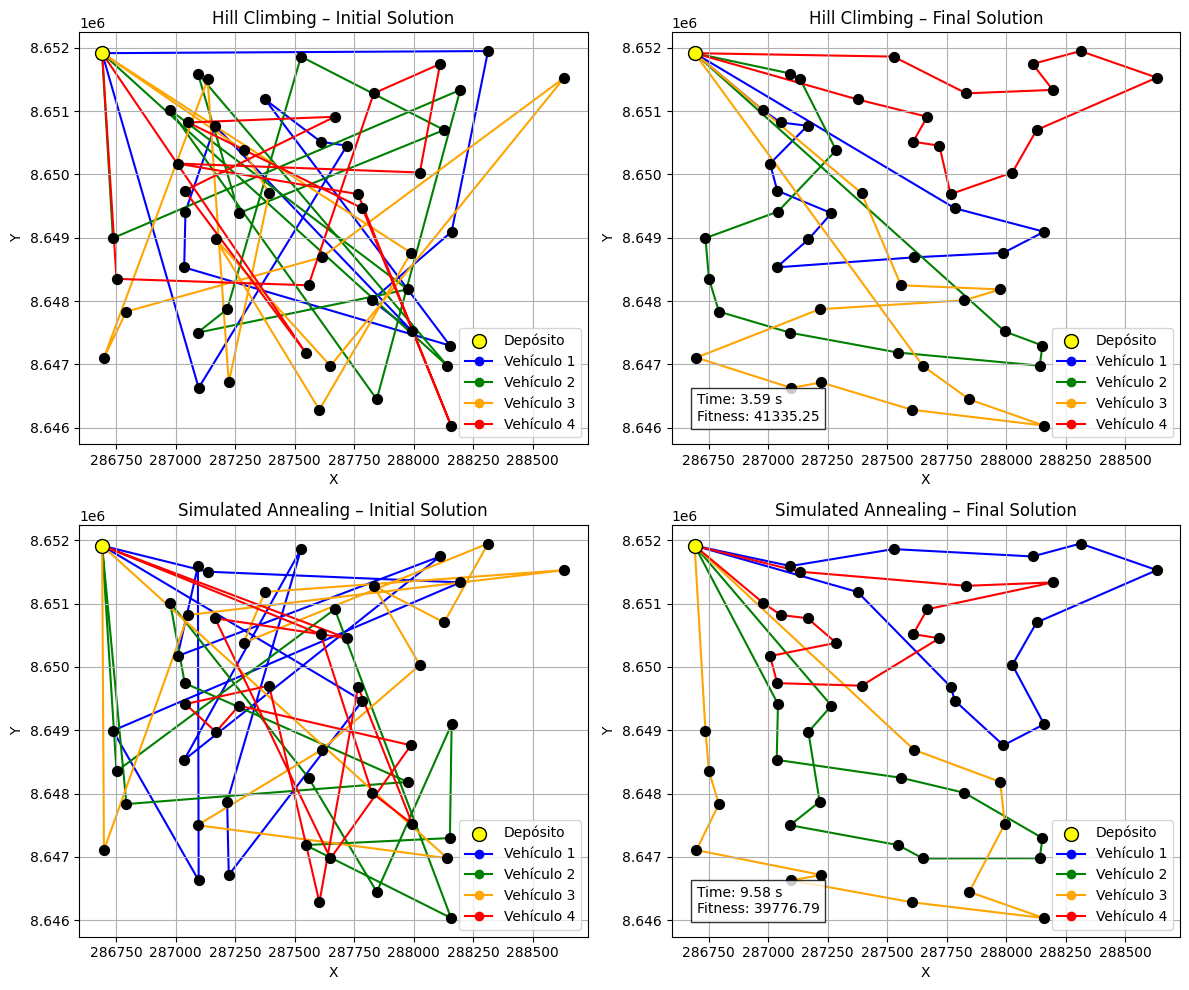

In [ ]:
import time

# par las pruebas usamos solo 'n' puntos
n_points = [10, 25, 50]
n_vehicles=[2, 3, 4]
cost_hc = []
cost_sa = []
time_hc = []
time_sa = []
combinations = [(n, v) for n in n_points for v in n_vehicles]
for n, v in combinations:
  df_reduced = df_long.iloc[:n, :n]
  positions = df_reduced[['x', 'y']].values
  # para  hill_climbing
  inicio_hc = time.time()
  sol_hc, final_cost_hc, init_sol_hc, init_cost_hc = hill_climbing_multi(positions, v)
  fin_hc = time.time()
  cost_hc.append(final_cost_hc)
  time_hc.append(fin_hc - inicio_hc)
  print("Inicial:", init_sol_hc, "\nCosto inicial:", init_cost_hc)
  print("Final:  ", sol_hc, "\nCosto final:  ", final_cost_hc)

  # para  simulated_annealing
  T_max = 2000
  T_min = 0.000001
  cooling_rate = 0.9999

  inicio_sa = time.time()
  sol_sa, final_cost_sa, init_sol_sa, init_cost_sa = simulated_annealing_multi(positions, v,T_max,T_min, cooling_rate)
  fin_sa = time.time()
  cost_sa.append(final_cost_sa)
  time_sa.append(fin_sa - inicio_sa)
  print("Inicial:", init_sol_sa, "\nCosto inicial:", init_cost_sa)
  print("Final:  ", sol_sa, "\nCosto final:  ", final_cost_sa)

  #Resultados
  route1 = init_sol_hc
  dist1 = init_sol_hc
  route2 = sol_hc
  dist2 = final_cost_hc

  route3 = init_sol_sa
  dist3 = init_sol_sa
  route4 = sol_sa
  dist4 = final_cost_sa

  fig, axs = plt.subplots(2, 2, figsize=(12, 10))

  plot_tsp_style_2(positions, route1, 'Hill Climbing – Initial Solution', axs[0][0])
  plot_tsp_style_2(positions, route2, 'Hill Climbing – Final Solution', axs[0][1], time=fin_hc - inicio_hc, fitness=dist2)
  plot_tsp_style_2(positions, route3, 'Simulated Annealing – Initial Solution', axs[1][0])
  plot_tsp_style_2(positions, route4, 'Simulated Annealing – Final Solution', axs[1][1], time=fin_sa - inicio_sa, fitness=dist4)

  plt.savefig(f'n_{n}_v_{v}.png')
  plt.tight_layout()
  plt.show()

# Resultados